In [1]:
# Importing Libraries


import re
import json
import requests
import numpy as np
from bs4 import BeautifulSoup

import pandas as pd
#display all rows
pd.set_option('display.max_rows', None)
#display all columns
pd.set_option('display.max_columns', None)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from geopy.geocoders import Nominatim

import folium

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

print('Libraries imported.')

Libraries imported.


### Data Requirements 
Chennai neighborhoods are derived along with their Latitude and Longitude from below site

https://chennaiiq.com/chennai/latitude_longitude_areas.asp

But the Latitude and Longitude data provided here is in Degrees Minute Seconds format. Thus before starting the analysis, the location data has to be converted to Decimal Degrees. 

In [2]:
url = 'https://chennaiiq.com/chennai/latitude_longitude_areas.asp'

html = requests.get(url)
print(html)

<Response [200]>


A Reponse value of 200 means that the process was successful.BeautifulSoup library is used to parse the html file in order to make it easier to access.

In [3]:
soup = BeautifulSoup(html.text, 'html.parser')
table = soup.find("table", attrs={"class": "TBox"})

html file has been parsed and will be used to build the dataset

### Data Collection

In [12]:
table_data = []
index = ['S.No.', 'Location', 'Latitude', 'Longitude']
for tr in table.find_all("tr", attrs={"class": "tab"}):
    t_row = {}
    for td, th in zip(tr.find_all("td"), index): 
        t_row[th] = td.text.replace('\n', '').strip()
    table_data.append(t_row)

chennai_data = pd.DataFrame(table_data[:-1], columns=index)
chennai_data.drop(columns=['S.No.'], inplace=True)
chennai_data.at[0,'Location'] = 'Adyar Bus Debot'
chennai_data.rename(columns={'Location': 'Neighborhood'}, inplace=True)
print(chennai_data.shape)
chennai_data.head(20)

(105, 3)


,Neighborhood,Latitude,Longitude
0,Adyar Bus Debot,"12°59'50"" N","80°15'25"" E"
1,Adyar Signal,"13°00'23"" N","80°15'27"" E"
2,Alandur,"13°00'28"" N","80°12'35"" E"
3,Ambattur,"13°06'36"" N","80°10'12"" E"
4,Anna Arch,"13°04'28"" N","80°13'06"" E"
5,Anna Nagar Roundana,"13°05'04"" N","80°13'05"" E"
6,Anna Nagar West Terminus,"13°05'35"" N","80°11'55"" E"
7,Anna Statue,"13°04'05"" N","80°16'19"" E"
8,Anna University Entrance,"13°00'29"" N","80°14'06"" E"
9,Avadi,"13°07'13"" N","80°06'36"" E"


In [ ]:
Converting Minute Seconds to Decimal Degrees

In [13]:
def dms2dd(s):
    degrees, minutes, seconds, direction = re.split('[°\'"]+', s)
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction in ('S','W'):
        dd*= -1
    return dd

chennai_data['Latitude'] = chennai_data['Latitude'].apply(dms2dd)
chennai_data['Longitude'] = chennai_data['Longitude'].apply(dms2dd)
print(chennai_data.shape)
chennai_data.head()

(105, 3)


,Neighborhood,Latitude,Longitude
0,Adyar Bus Debot,12.997222,80.256944
1,Adyar Signal,13.006389,80.257500
2,Alandur,13.007778,80.209722
3,Ambattur,13.110000,80.170000
4,Anna Arch,13.074444,80.218333


Visualizing the chennai using Folium library.

In [14]:
address = 'Chennai, Tamil Nadu'

geolocator = Nominatim(user_agent="chennai_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of chennai are {}, {}.'.format(latitude, longitude))

The geographical coordinate of chennai are 13.0836939, 80.270186.


In [17]:
chennai_map = folium.Map(location=[latitude, longitude], zoom_start=11)    
chennai_map

### Adding neighborhoods in the map

In [18]:
for lat, lng, location in zip(chennai_data['Latitude'], chennai_data['Longitude'], chennai_data['Neighborhood']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(chennai_map)  

chennai_map

### Defining Four Square Credentials and Versions

In [24]:
CLIENT_ID = 'ZUBR40S2KJRARFFU2DHWPKCDSZMPRCXB3XB152ABNBC4UJES' # your Foursquare ID
CLIENT_SECRET = 'I22I4KN1RT4M0EP3PXVF24VFD53YPQUVTXXJIBYRZ0VF2Y5W' # your Foursquare Secret
VERSION = '20190130' # Foursquare API version

### Exploring neighborhoods in Chennai

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        count = 1
        while count != 5:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                count = 5
            except:
                count += 1
    
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

I am going to use the above function on the chennai_data neighborhoods dataframe and store the venues data returned in the chennai_venues pandas dataframe.

In [23]:

chennai_venues = getNearbyVenues(names = chennai_data['Neighborhood'],
                                 latitudes = chennai_data['Latitude'],
                                 longitudes = chennai_data['Longitude']
                                 )

print(chennai_venues.shape)
chennai_venues.head(10)

(1164, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adyar Bus Debot,12.997222,80.256944,Zaitoon Restaurant,12.996861,80.256178,Middle Eastern Restaurant
1,Adyar Bus Debot,12.997222,80.256944,Kuttanadu Restaurant,12.997010,80.257799,Asian Restaurant
2,Adyar Bus Debot,12.997222,80.256944,Zha Cafe,12.999730,80.254806,Café
3,Adyar Bus Debot,12.997222,80.256944,"Adyar Ananda Bhavan, Besant Nagar",12.996678,80.258275,Fast Food Restaurant
4,Adyar Bus Debot,12.997222,80.256944,Kovai Pazhamudir Nilayam,12.996522,80.259776,Fruit & Vegetable Store
5,Adyar Bus Debot,12.997222,80.256944,Barbeque N Biryani,12.995907,80.256011,BBQ Joint
6,Adyar Bus Debot,12.997222,80.256944,Subway,12.999040,80.254743,Sandwich Place
7,Adyar Bus Debot,12.997222,80.256944,Mast Kalandar,12.996567,80.260155,Indian Restaurant
8,Adyar Bus Debot,12.997222,80.256944,Domino's Pizza,13.001470,80.256626,Pizza Place
9,Adyar Bus Debot,12.997222,80.256944,Rotiwala (A Unit of Indian Chat Corner),13.001044,80.258006,Fast Food Restaurant


In [26]:
# No of venues returned per neighborhood

chennai_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
AVM Studio,7,7,7,7,7,7
Adyar Bus Debot,14,14,14,14,14,14
Adyar Signal,35,35,35,35,35,35
Alandur,13,13,13,13,13,13
Ambattur,1,1,1,1,1,1
Anna Arch,14,14,14,14,14,14
Anna Nagar Roundana,20,20,20,20,20,20
Anna Nagar West Terminus,8,8,8,8,8,8
Anna Statue,12,12,12,12,12,12


In [27]:
# Lets check for unique categories of venues returned

print('There are {} uniques categories.'.format(len(chennai_venues['Venue Category'].unique())))

There are 142 uniques categories.


### Methodology

We are having 142 Unique categories across chennai and for analysis purpose we will consider the neighborhoods having more than 15 venues and ignoring below 15.

We can perform one hot encoding on the obtained data set and use it find the 15 most common venue category in each neighborhood. Then clustering can be performed on the dataset. Here K - Nearest Neighbor clustering technique have been used. To find the optimal number of clusters silhouette score metric technique is used.The clusters obtained can be analyzed to find the major type of venue categories in each cluster. This data can be used to suggest business people, suitable locations based on the category.

### Analysis

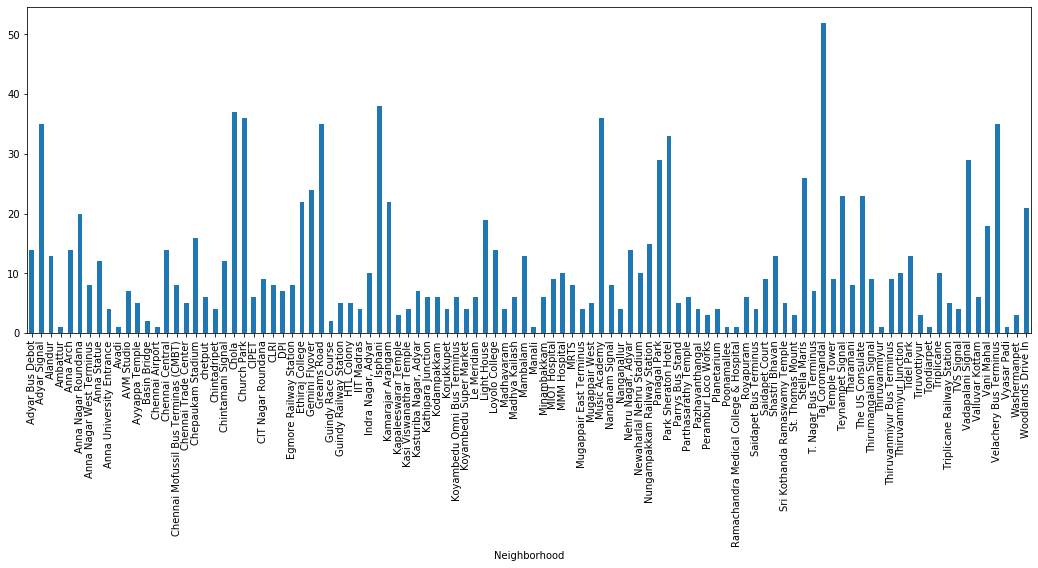

In [28]:
#  visualizing the no of venues obtained in all neighborhoods of chennai
df = chennai_venues.groupby(['Neighborhood'], sort=False)['Venue'].count()
df.plot.bar(figsize=(18,6))

We are going to remove neighborhoods having less than 15 venues

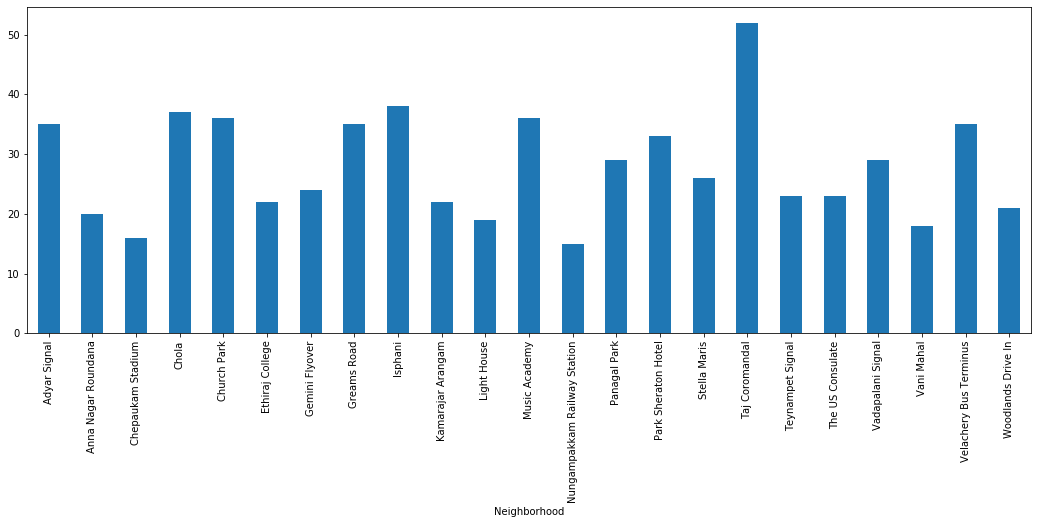

In [29]:
df = df[df >= 15]
df.plot.bar(figsize=(18,6))

In [ ]:
Now the plot looks good and visualization seems better. Now i am creating new df for storing Top 10 Neighborhoods 
having 15+ venues

In [30]:
chennai_venues_top = chennai_venues[chennai_venues['Neighborhood'].isin(df.index.tolist())]
chennai_venues_top.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
14,Adyar Signal,13.006389,80.2575,Bombay Brassiere,13.006961,80.256419,North Indian Restaurant
15,Adyar Signal,13.006389,80.2575,Cool Biz,13.006632,80.257275,Juice Bar
16,Adyar Signal,13.006389,80.2575,Prems Graama Bhojanam,13.006345,80.253995,Vegetarian / Vegan Restaurant
17,Adyar Signal,13.006389,80.2575,Gangotree,13.007435,80.258361,Snack Place
18,Adyar Signal,13.006389,80.2575,McDonald's,13.006632,80.254255,Fast Food Restaurant


In [31]:
# one hot encoding
chennai_onehot = pd.get_dummies(chennai_venues_top['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chennai_onehot['Neighborhood'] = chennai_venues_top['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = chennai_onehot.columns.tolist()
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighborhood')))
chennai_onehot = chennai_onehot.reindex(columns = fixed_columns)

print(chennai_onehot.shape)
chennai_onehot.head()

(644, 98)


,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Amphitheater,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beach,Bengali Restaurant,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Buffet,Bus Station,Cafeteria,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Coworking Space,Department Store,Dessert Shop,Diner,Donut Shop,Electronics Store,Fast Food Restaurant,Food Court,Furniture / Home Store,Gaming Cafe,Garden,General Entertainment,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Movie Theater,Multiplex,Music Store,Music Venue,Nightclub,North Indian Restaurant,Paper / Office Supplies Store,Park,Pizza Place,Pool,Pub,Ramen Restaurant,Recreation Center,Restaurant,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Sculpture Garden,Shoe Store,Shopping Mall,Snack Place,South Indian Restaurant,Spa,Steakhouse,Tea Room,Thai Restaurant,Train Station,Vegetarian / Vegan Restaurant,Women's Store
14,Adyar Signal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,Adyar Signal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16,Adyar Signal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
17,Adyar Signal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
18,Adyar Signal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
Grouping the data by neighborhood and taking the mean value of the frequency of occurrence of each category.

In [32]:
chennai_grouped = chennai_onehot.groupby('Neighborhood').mean().reset_index()
print(chennai_grouped.shape)
chennai_grouped.head()

(23, 98)


,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Amphitheater,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beach,Bengali Restaurant,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Buffet,Bus Station,Cafeteria,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Coworking Space,Department Store,Dessert Shop,Diner,Donut Shop,Electronics Store,Fast Food Restaurant,Food Court,Furniture / Home Store,Gaming Cafe,Garden,General Entertainment,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Movie Theater,Multiplex,Music Store,Music Venue,Nightclub,North Indian Restaurant,Paper / Office Supplies Store,Park,Pizza Place,Pool,Pub,Ramen Restaurant,Recreation Center,Restaurant,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Sculpture Garden,Shoe Store,Shopping Mall,Snack Place,South Indian Restaurant,Spa,Steakhouse,Tea Room,Thai Restaurant,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Adyar Signal,0.0,0.000000,0.0,0.0,0.028571,0.000000,0.028571,0.0,0.0,0.028571,0.0,0.000000,0.0,0.000000,0.0,0.028571,0.0,0.0,0.0000,0.0,0.0,0.0000,0.028571,0.000000,0.0,0.000000,0.028571,0.000000,0.000000,0.0,0.0,0.0,0.028571,0.0,0.0,0.057143,0.028571,0.0,0.0,0.000000,0.000000,0.0000,0.028571,0.028571,0.000000,0.028571,0.0,0.000000,0.00,0.028571,0.285714,0.028571,0.0,0.0,0.057143,0.0,0.000000,0.0,0.0,0.028571,0.0,0.0000,0.0,0.000000,0.000000,0.0,0.0,0.028571,0.000000,0.0,0.0,0.000000,0.057143,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.028571,0.0,0.0,0.000000,0.0,0.028571,0.0,0.028571,0.000000,0.0,0.0,0.000000,0.0,0.0,0.028571,0.0
1,Anna Nagar Roundana,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.050000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.050000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.050000,0.100000,0.0,0.050000,0.050000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.050000,0.050000,0.0,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.05,0.000000,0.250000,0.000000,0.0,0.0,0.050000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0000,0.0,0.000000,0.050000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.05,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.050000,0.0,0.0,0.000000,0.0,0.0,0.050000,0.0
2,Chepaukam Stadium,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.062500,0.0,0.000000,0.0,0.062500,0.0,0.0,0.0625,0.0,0.0,0.0625,0.062500,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.062500,0.000000,0.0,0.0,0.000000,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.0,0.062500,0.00,0.000000,0.375000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0625,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.062500,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,Chola,0.0,0.027027,0.0,0.0,0.000000,0.027027,0.000000,0.0,0.0,0.000000,0.0,0.027027,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.027027,0.027027,0.0,0.000000,0.000000,0.027027,0.054054,0.0,0.0,0.0,0.027027,0.0,0.0,0.027027,0.000000,0.0,0.0,0.000000,0.027027,0.0000,0.000000,0.027027,0.027027,0.000000,0.0,0.108108,0.00,0.054054,0.189189,0.027027,0.0,0.0,0.027027,0.0,0.027027,0.0,0.0,0.027027,0.0,0.0000,0.0,0.027027,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.027027,0.0,0.0,0.054054,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.027027,0.0,0.0,0.027027,0.0,0.0,0.027027,0.0
4

In [33]:
# Returning Top venues for each neighborhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
Lets use the above function to obtain the 10 most common venues in each neighborhood and store in the new df

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create column names according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chennai_grouped['Neighborhood']

for ind in np.arange(chennai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chennai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Signal,Indian Restaurant,Electronics Store,Juice Bar,North Indian Restaurant,Café,Bookstore,Grocery Store,Gym / Fitness Center,Vegetarian / Vegan Restaurant,Ice Cream Shop
1,Anna Nagar Roundana,Indian Restaurant,Chinese Restaurant,Hotel Bar,Bookstore,Vegetarian / Vegan Restaurant,Juice Bar,Fast Food Restaurant,Electronics Store,Middle Eastern Restaurant,Coffee Shop
2,Chepaukam Stadium,Indian Restaurant,Hotel,Bar,Café,Cafeteria,Breakfast Spot,Mediterranean Restaurant,Bookstore,Multiplex,Electronics Store
3,Chola,Indian Restaurant,Hotel,Restaurant,Concert Hall,Ice Cream Shop,Garden,Café,Lounge,Dessert Shop,Kerala Restaurant
4,Church Park,Indian Restaurant,Multiplex,Movie Theater,Chinese Restaurant,Middle Eastern Restaurant,Café,Hotel,Bakery,Park,Pool


### Cluster Neighborhoods : K-Nearest Neighborhoods

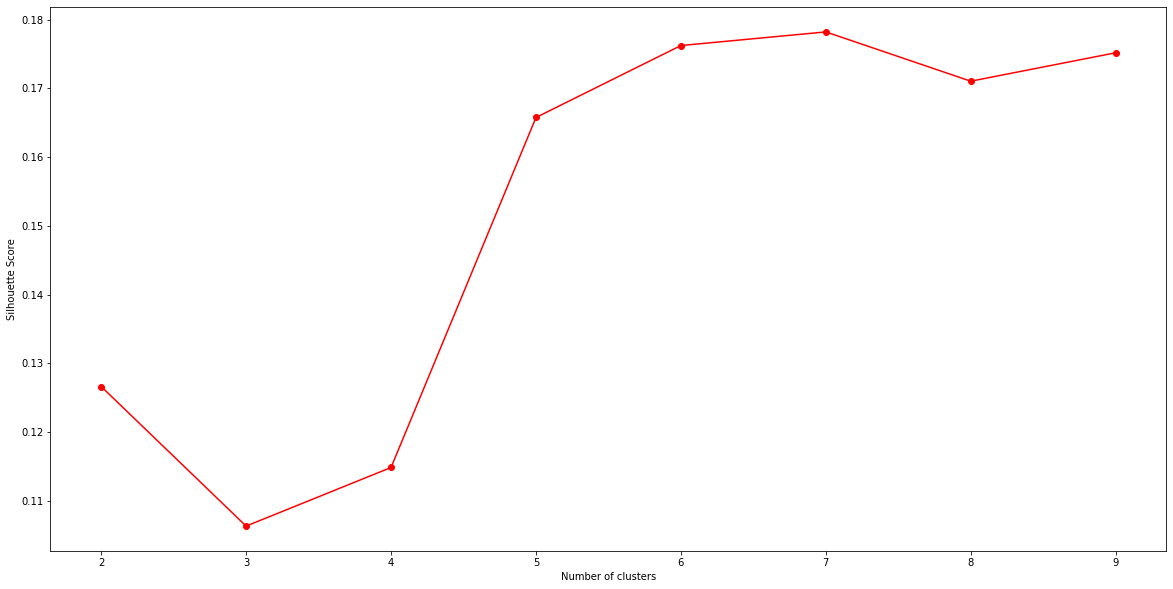

In [35]:
# using silhoute score to obtain best value for no of clusters
chennai_grouped_clustering = chennai_grouped.drop('Neighborhood', 1)

max_score = 10
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(chennai_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(chennai_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

As seen from the above line plot, the best number of clusters having the highest silhouette score is 8. So, lets consider the number of clusters as 8.

In [36]:

# selecting best number of clusters
kclusters = 9

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chennai_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 4, 4, 0, 3, 0, 2, 3, 2, 2])

In [ ]:
Add the cluster labels to the neighborhoods_venues_sorted dataframe. And lets create a new datframe chennai_merged which has the neighborhood details, 
cluster labels and the 10 most common venues in that neighborhood.

In [37]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

chennai_merged = chennai_venues_top[chennai_venues_top.columns[0:3]].drop_duplicates()
chennai_merged.reset_index(drop = True, inplace = True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
chennai_merged = chennai_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

chennai_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Signal,13.006389,80.257500,4,Indian Restaurant,Electronics Store,Juice Bar,North Indian Restaurant,Café,Bookstore,Grocery Store,Gym / Fitness Center,Vegetarian / Vegan Restaurant,Ice Cream Shop
1,Anna Nagar Roundana,13.084444,80.218056,4,Indian Restaurant,Chinese Restaurant,Hotel Bar,Bookstore,Vegetarian / Vegan Restaurant,Juice Bar,Fast Food Restaurant,Electronics Store,Middle Eastern Restaurant,Coffee Shop
2,Chepaukam Stadium,13.064167,80.266389,4,Indian Restaurant,Hotel,Bar,Café,Cafeteria,Breakfast Spot,Mediterranean Restaurant,Bookstore,Multiplex,Electronics Store
3,Chola,13.044167,80.259722,0,Indian Restaurant,Hotel,Restaurant,Concert Hall,Ice Cream Shop,Garden,Café,Lounge,Dessert Shop,Kerala Restaurant
4,Church Park,13.053889,80.254444,3,Indian Restaurant,Multiplex,Movie Theater,Chinese Restaurant,Middle Eastern Restaurant,Café,Hotel,Bakery,Park,Pool


### Run the clusters


In [52]:
# Cluster 1

chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Chola,Indian Restaurant,Hotel,Restaurant,Concert Hall,Ice Cream Shop,Garden,Café,Lounge,Dessert Shop,Kerala Restaurant
5,Ethiraj College,Hotel,Café,Indian Restaurant,Pizza Place,Kebab Restaurant,Juice Bar,Athletics & Sports,Shopping Mall,Fast Food Restaurant,Middle Eastern Restaurant
11,Music Academy,Indian Restaurant,Hotel,Café,Concert Hall,Restaurant,Ice Cream Shop,Gym,Italian Restaurant,Pub,Juice Bar
15,Stella Maris,Indian Restaurant,Hotel,Women's Store,Bar,Fast Food Restaurant,Ice Cream Shop,Italian Restaurant,Jewelry Store,Juice Bar,Kerala Restaurant
17,Teynampet Signal,Lounge,Indian Restaurant,Hotel,Pizza Place,Pub,Italian Restaurant,Spa,Mediterranean Restaurant,Juice Bar,Chinese Restaurant


In [53]:
cluster1 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))


Indian Restaurant     5
Hotel                 5
Juice Bar             4
Italian Restaurant    3
Ice Cream Shop        3
Café                  3
Kerala Restaurant     2
Restaurant            2
Pizza Place           2
Pub                   2
dtype: int64


In [54]:
# Cluster 2

chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]



,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Light House,Fast Food Restaurant,Coffee Shop,Department Store,Train Station,Multiplex,American Restaurant,Beach,Bar,Snack Place,Shopping Mall


In [55]:
cluster2 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))

print(venues2.value_counts().head(10))

Snack Place             1
American Restaurant     1
Bar                     1
Train Station           1
Department Store        1
Beach                   1
Multiplex               1
Shopping Mall           1
Fast Food Restaurant    1
Coffee Shop             1
dtype: int64


In [56]:
# cluster 3

chennai_merged.loc[chennai_merged['Cluster Labels'] == 2, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Gemini Flyover,Coffee Shop,Hotel,Nightclub,Sandwich Place,Indian Restaurant,Park,Pool,Department Store,Bengali Restaurant,Bar
8,Isphani,Indian Restaurant,Hotel,Chinese Restaurant,Café,Nightclub,Coffee Shop,Sandwich Place,Lounge,Pizza Place,South Indian Restaurant
9,Kamarajar Arangam,Hotel,Café,Nightclub,Indian Restaurant,Lounge,Coffee Shop,Bistro,Pizza Place,Park,Coworking Space
14,Park Sheraton Hotel,Hotel,Café,Restaurant,Coffee Shop,Nightclub,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Chinese Restaurant,Thai Restaurant
18,The US Consulate,Coffee Shop,Nightclub,Hotel,Indian Restaurant,Sandwich Place,BBQ Joint,Chinese Restaurant,Café,Lounge,Department Store
22,Woodlands Drive In,Indian Restaurant,Hotel,Nightclub,Department Store,Lounge,Park,Bar,BBQ Joint,Chinese Restaurant,Ice Cream Shop


In [57]:
cluster3 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 2, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues3 = (cluster3['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue']).append(
    cluster3['6th Most Common Venue']).append(
    cluster3['7th Most Common Venue']).append(
    cluster3['8th Most Common Venue']).append(
    cluster3['9th Most Common Venue']).append(
    cluster3['10th Most Common Venue']))

print(venues3.value_counts().head(10))

Indian Restaurant     6
Nightclub             6
Hotel                 6
Coffee Shop           5
Lounge                4
Chinese Restaurant    4
Café                  4
Department Store      3
Sandwich Place        3
Park                  3
dtype: int64


In [58]:
# Cluster 4
chennai_merged.loc[chennai_merged['Cluster Labels'] == 3, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]



,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Church Park,Indian Restaurant,Multiplex,Movie Theater,Chinese Restaurant,Middle Eastern Restaurant,Café,Hotel,Bakery,Park,Pool
7,Greams Road,Movie Theater,Multiplex,Café,Indian Restaurant,Middle Eastern Restaurant,Juice Bar,Bakery,Chinese Restaurant,Mexican Restaurant,Buffet


In [59]:
cluster4 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 3, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues4 = (cluster4['1st Most Common Venue'].append(
    cluster4['2nd Most Common Venue']).append(
    cluster4['3rd Most Common Venue']).append(
    cluster4['4th Most Common Venue']).append(
    cluster4['5th Most Common Venue']).append(
    cluster4['6th Most Common Venue']).append(
    cluster4['7th Most Common Venue']).append(
    cluster4['8th Most Common Venue']).append(
    cluster4['9th Most Common Venue']).append(
    cluster4['10th Most Common Venue']))

print(venues4.value_counts().head(10))

Middle Eastern Restaurant    2
Chinese Restaurant           2
Multiplex                    2
Movie Theater                2
Café                         2
Bakery                       2
Indian Restaurant            2
Buffet                       1
Pool                         1
Hotel                        1
dtype: int64


In [60]:
# Cluster 5

chennai_merged.loc[chennai_merged['Cluster Labels'] == 4, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]



,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Signal,Indian Restaurant,Electronics Store,Juice Bar,North Indian Restaurant,Café,Bookstore,Grocery Store,Gym / Fitness Center,Vegetarian / Vegan Restaurant,Ice Cream Shop
1,Anna Nagar Roundana,Indian Restaurant,Chinese Restaurant,Hotel Bar,Bookstore,Vegetarian / Vegan Restaurant,Juice Bar,Fast Food Restaurant,Electronics Store,Middle Eastern Restaurant,Coffee Shop
2,Chepaukam Stadium,Indian Restaurant,Hotel,Bar,Café,Cafeteria,Breakfast Spot,Mediterranean Restaurant,Bookstore,Multiplex,Electronics Store
16,Taj Coromandal,Indian Restaurant,Café,Chinese Restaurant,Sandwich Place,Italian Restaurant,Pizza Place,Asian Restaurant,Ice Cream Shop,Fast Food Restaurant,Dessert Shop
21,Velachery Bus Terminus,Indian Restaurant,Fast Food Restaurant,Clothing Store,Chinese Restaurant,Department Store,Ice Cream Shop,Restaurant,Accessories Store,Multiplex,Liquor Store


In [61]:
cluster5 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 4, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues5 = (cluster5['1st Most Common Venue'].append(
    cluster5['2nd Most Common Venue']).append(
    cluster5['3rd Most Common Venue']).append(
    cluster5['4th Most Common Venue']).append(
    cluster5['5th Most Common Venue']).append(
    cluster5['6th Most Common Venue']).append(
    cluster5['7th Most Common Venue']).append(
    cluster5['8th Most Common Venue']).append(
    cluster5['9th Most Common Venue']).append(
    cluster5['10th Most Common Venue']))

print(venues5.value_counts().head(10))

Indian Restaurant                5
Fast Food Restaurant             3
Café                             3
Bookstore                        3
Ice Cream Shop                   3
Electronics Store                3
Chinese Restaurant               3
Juice Bar                        2
Multiplex                        2
Vegetarian / Vegan Restaurant    2
dtype: int64


In [62]:
# Cluster 6
chennai_merged.loc[chennai_merged['Cluster Labels'] == 5, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]



,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Vani Mahal,Indian Restaurant,Hotel,Clothing Store,Coffee Shop,Vegetarian / Vegan Restaurant,Music Venue,BBQ Joint,Department Store,Pub,Boutique


In [63]:
cluster6 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 5, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues6 = (cluster6['1st Most Common Venue'].append(
    cluster6['2nd Most Common Venue']).append(
    cluster6['3rd Most Common Venue']).append(
    cluster6['4th Most Common Venue']).append(
    cluster6['5th Most Common Venue']).append(
    cluster6['6th Most Common Venue']).append(
    cluster6['7th Most Common Venue']).append(
    cluster6['8th Most Common Venue']).append(
    cluster6['9th Most Common Venue']).append(
    cluster6['10th Most Common Venue']))

print(venues6.value_counts().head(10))

Music Venue                      1
BBQ Joint                        1
Boutique                         1
Hotel                            1
Department Store                 1
Pub                              1
Clothing Store                   1
Vegetarian / Vegan Restaurant    1
Indian Restaurant                1
Coffee Shop                      1
dtype: int64


In [64]:
# cluster 7

chennai_merged.loc[chennai_merged['Cluster Labels'] == 6, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]



,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Vadapalani Signal,Clothing Store,Indian Restaurant,Multiplex,Asian Restaurant,Vegetarian / Vegan Restaurant,South Indian Restaurant,Fast Food Restaurant,Café,Market,Pizza Place


In [ ]:
cluster7 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 6, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues7 = (cluster7['1st Most Common Venue'].append(
    cluster7['2nd Most Common Venue']).append(
    cluster7['3rd Most Common Venue']).append(
    cluster7['4th Most Common Venue']).append(
    cluster7['5th Most Common Venue']).append(
    cluster7['6th Most Common Venue']).append(
    cluster7['7th Most Common Venue']).append(
    cluster7['8th Most Common Venue']).append(
    cluster7['9th Most Common Venue']).append(
    cluster7['10th Most Common Venue']))

print(venues7.value_counts().head(10))

In [65]:
# cluster 8

chennai_merged.loc[chennai_merged['Cluster Labels'] == 7, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Panagal Park,Clothing Store,Indian Restaurant,Jewelry Store,Women's Store,BBQ Joint,Coffee Shop,Concert Hall,Park,Pizza Place,Boutique


In [66]:
cluster8 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 7, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues8 = (cluster8['1st Most Common Venue'].append(
    cluster8['2nd Most Common Venue']).append(
    cluster8['3rd Most Common Venue']).append(
    cluster8['4th Most Common Venue']).append(
    cluster8['5th Most Common Venue']).append(
    cluster8['6th Most Common Venue']).append(
    cluster8['7th Most Common Venue']).append(
    cluster8['8th Most Common Venue']).append(
    cluster8['9th Most Common Venue']).append(
    cluster8['10th Most Common Venue']))

print(venues8.value_counts().head(10))

BBQ Joint            1
Boutique             1
Jewelry Store        1
Women's Store        1
Concert Hall         1
Pizza Place          1
Park                 1
Clothing Store       1
Indian Restaurant    1
Coffee Shop          1
dtype: int64


### Discussion

Lets visulaize the top 5 most common venue categories in each of the cluster

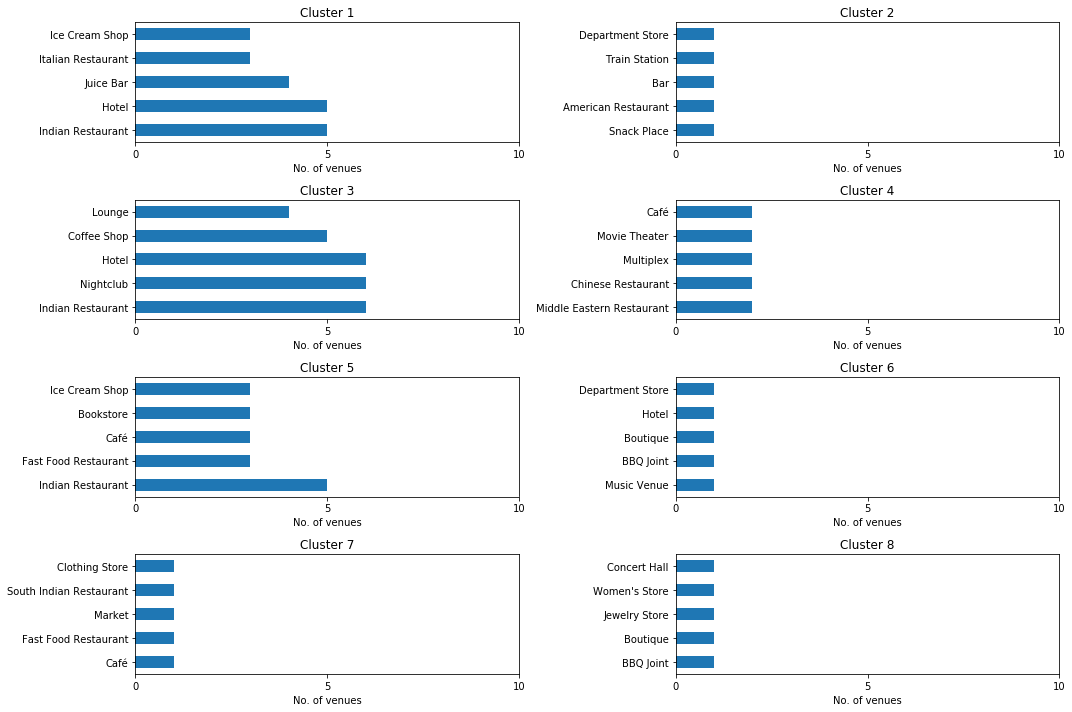

In [67]:
df_list = [venues1 ,venues2, venues3, venues4, venues5, venues6, venues7, venues8]
fig, axes = plt.subplots(4, 2)

count = 0
for r in range(4):
    for c in range(2):
        df_list[count].value_counts().head().plot.barh(ax = axes[r,c], width=0.5, figsize=(15,10))
        axes[r,c].set_title('Cluster {}'.format(count+1))
        plt.sca(axes[r, c])
        plt.xticks(np.arange(0, 15, 5))
        plt.xlabel('No. of venues')
        count += 1

fig.tight_layout()

Above plot can be used to find Restaurants and malls available in particular area. Cluster 1 - Areas : Alwarpet around, Teynampet Signal around , Cluster 3 - Areas : Gemini Flyover, around Nungambakkam and Cluster 5 -  Areas : Around Adyar Signal, Anna Nagar Roundtana, Velachery bus terminus, Chepauk Stadium are having variety of food outlets. So, One can visit these areas if they want to taste different varieties of foods.
Cluster 2, Cluster 7 and Cluster 8 are having very less variety of food outlets.


In [68]:
# Lets superimpose the clusters in the Chennai map


# create map
chennai_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chennai_merged['Neighborhood Latitude'], chennai_merged['Neighborhood Longitude'], chennai_merged['Neighborhood'], chennai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(chennai_clusters_map)
       
chennai_clusters_map

### Result

With Chennai developing very fast and becomes IT hub, new restaurants are emerging quickly. We need a system that could help us access vast number of food varieties. It’s impossible for a person to ask each and every one about their visit to a particular place and also not every one remembers everything. 
On the other hand computers remembers everything and machine learning evolves to its peak, its high time technology will be our personal guidance and help us personally based on our likes and dislikes. So people would care about the project as their personal assistance and success rate could increase with time.

The neighborhoods data was obtained from an online source and the Foursquare API was used to find the major venues in each neighborhood. But we found that many neighborhoods had less than 10 venues returned. In order to build a good Data Science model, we filtered out these locations. The remaining locations were used to create a clustering model. The best number of clusters i.e. 8 was obtained using the silhouette score. Each cluster was examined to find the most venue categories present, that defines the characteristics for that particular cluster.So one can easily find out the food outlets using this project but still we can seet that foursqure is not upto date and in future this can resolved using better data source with latest update.